In [26]:
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import models
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

import math

In [27]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1) 
x_train = x_train.astype('float32')/255.0
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test.astype('float32')/255.0
print(x_train.shape)
x_train1, x_val, y_train1, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
y_train_categorical = tf.keras.utils.to_categorical(y_train1, num_classes=10)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10)
def flatten( X):
        return X.reshape(X.shape[0], -1)#nx784

x_train2= flatten(x_train1)
x_test_flat=flatten(x_test)
x_val_flat = flatten (x_val)
print(x_val_flat.shape)

(60000, 28, 28, 1)
(6000, 784)


In [28]:
def to_categorical(y, num_classes):
    category = np.zeros((len(y), num_classes))
    
    for i in range(len(y)):
        category[i, y[i]] = 1
        
    return category

num_classes = 10  
y_train_categorical = to_categorical(y_train1, num_classes)
y_val_categorical= to_categorical(y_val, num_classes)
y_test_categorical= to_categorical(y_test, num_classes)



In [29]:
def custom_augmentation(images):
  augmenter = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 1.0)),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Fliplr(0.5),
    #iaa.Flipud(0.5),
   # iaa.PerspectiveTransform(scale=(0.01, 0.15)) ,
   # iaa.Affine(shear=(-10, 10)),
   # iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),
   # iaa.Crop(px=(0, 10))
  ])
  return augmenter.augment_images(images)

x_train_augmented = custom_augmentation(x_train1)
x_train_aug_flat=flatten(x_train_augmented)


In [30]:
def flatten( X):
        return X.reshape(X.shape[0], -1)#nx784

def initiate_parameters( input_shape, hiddenunits1, hiddenunits2, output_units):   

        W1 = np.random.randn(input_shape[0], hiddenunits1) * np.sqrt(2 / (input_shape[0] + hiddenunits1))  #784x128
        b1 = np.random.randn(1, hiddenunits1) * 0.01
        W2 = np.random.randn(hiddenunits1, hiddenunits2) * np.sqrt(2 / (hiddenunits1 + hiddenunits2)) #128x64
        b2 = np.random.randn(1, hiddenunits2) * 0.01
        W3 = np.random.randn(hiddenunits2, output_units) *np.sqrt(2 / (hiddenunits2 + output_units)) #normal xavier initialisation          #64x10
        b3 = np.random.randn(1, output_units) * 0.01
        return W1,b1,W2,b2,W3,b3

    
def relu(x):
        return np.maximum(0, x)
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
def ReLU_deriv(x):
        return x > 0  
       
def forward(X_flattened,W1,b1,W2,b2,W3,b3):

        Z1 = np.dot(X_flattened, W1) + b1 #nx784 dot 784x128=nx128 
        A1 = relu(Z1)
       
        Z2 = np.dot(A1, W2) + b2 
        A2 = relu(Z2)

        Z3 = np.dot(A2, W3) + b3
        #print(b3.shape) #nx10
        A3 = softmax(Z3)
        return Z1,A1,Z2,A2,Z3,A3

def cross_entropy_loss(y_pred, y_true):
    num_samples = y_pred.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip values to avoid division by zero
    y_true_indices = np.argmax(y_true, axis=1)

    log_likelihood = -np.log(y_pred_clipped[range(num_samples), y_true_indices])
    loss = np.sum(log_likelihood) / num_samples
    return loss


    


In [31]:

def backward_prop(input_shape,Z1, A1, Z2, A2,Z3,A3, W1, W2,W3, X, Y):
       dZ3 = (A3 - Y)                                   #nx10
       dW3 = (1 / input_shape[0]) *  np.dot(A2.T,dZ3)        #64x10
       db3 = (1 / input_shape[0]) * np.sum(dZ3,axis=1,keepdims=True)
       dZ2 = np.dot(dZ3,W3.T) * ReLU_deriv(Z2)    #nx64
       dW2 = (1 / input_shape[0]) * np.dot(A1.T,dZ2) #128x64
       db2 = (1 / input_shape[0]) * np.sum(dZ2)
       dZ1 = np.dot(dZ2,W2.T) * ReLU_deriv(Z1) #nx128
       dW1 = (1 / input_shape[0])* np.dot(X.T,dZ1) 
       db1 = (1 / input_shape[0]) * np.sum(dZ1)
       return dW1, db1, dW2, db2,dW3,db3

def update_params(W1, b1, W2, b2,W3,b3, dW1, db1, dW2, db2,dW3,db3, alpha):
     W1 = W1 - alpha * dW1
     b1 = b1 - alpha * db1    
     W2 = W2 - alpha * dW2  
     b2 = b2 - alpha * db2  
     W3 = W3 - alpha * dW3  
     b3 = b3 - alpha * db3   
     return W1, b1, W2, b2 , W3, b3

input_shape = (28 * 28, 1)
hiddenunits1 = 128
hiddenunits2 = 64
output_units = 10

In [32]:
def get_predictions(A3):
    return np.argmax(A3, 1)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.mean(predictions == Y) 


def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3 = initiate_parameters(input_shape, hiddenunits1, hiddenunits2, output_units)
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3  = forward(X, W1, b1, W2, b2, W3, b3)
        loss=cross_entropy_loss(A3,y_train_categorical)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(input_shape,Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, x_train_aug_flat, Y)
       
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2,W3,b3,dW1, db1, dW2, db2,dW3,db3,alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
          # predictions = get_predictions(A3)
            print("loss: ",loss)
           
           # print("b3 shape: ", b3.shape  )

           
                 
    return W1, b1, W2, b2, W3,b3

W11, b11, W21, b21 , W31, b31 = gradient_descent(x_train_aug_flat, y_train_categorical, 0.002, 750)


Iteration:  0
loss:  2.3112383134625825
Iteration:  10
loss:  1.6802204364253444
Iteration:  20
loss:  1.1304538797369985
Iteration:  30
loss:  1.0096784202430114
Iteration:  40
loss:  0.9544631543365869
Iteration:  50
loss:  0.7910174351838499
Iteration:  60
loss:  0.7401654855154752
Iteration:  70
loss:  0.7012112960305387
Iteration:  80
loss:  0.6743783832198587
Iteration:  90
loss:  0.7179721165340088
Iteration:  100
loss:  0.6241219372651198
Iteration:  110
loss:  0.626080226268418
Iteration:  120
loss:  0.5976883482147944
Iteration:  130
loss:  0.586551899771636
Iteration:  140
loss:  0.572818861652843
Iteration:  150
loss:  0.5579886382108323
Iteration:  160
loss:  0.5468452961570124
Iteration:  170
loss:  0.5374873356198532
Iteration:  180
loss:  0.5284006643898322
Iteration:  190
loss:  0.5161165991498904
Iteration:  200
loss:  0.5044143750054517
Iteration:  210
loss:  0.4940915083421057
Iteration:  220
loss:  0.48461462847078474
Iteration:  230
loss:  0.47796642674640794
Iter

[7 2 1 ... 4 5 6] [7 2 1 ... 4 5 6]
Testing Accuracy: 0.9261
Prediction:  [7 2 1 ... 4 5 6]
Label:  3


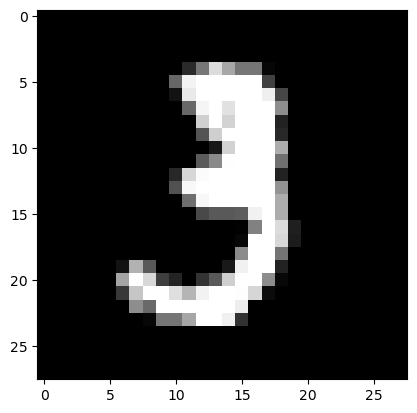

Prediction:  [7 2 1 ... 4 5 6]
Label:  8


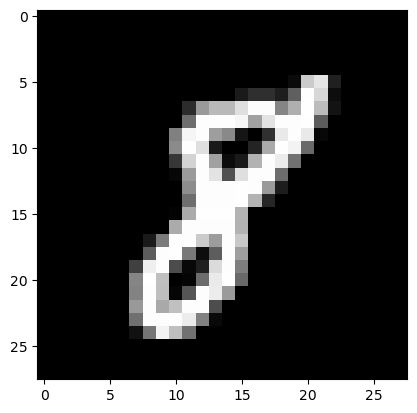

Prediction:  [7 2 1 ... 4 5 6]
Label:  1


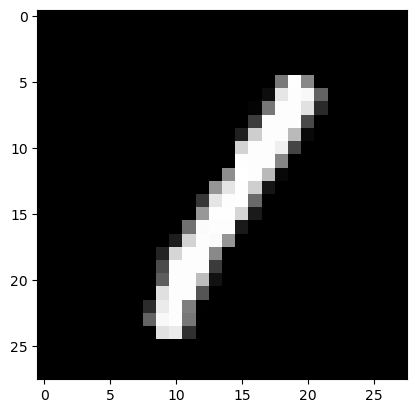

Prediction:  [7 2 1 ... 4 5 6]
Label:  9


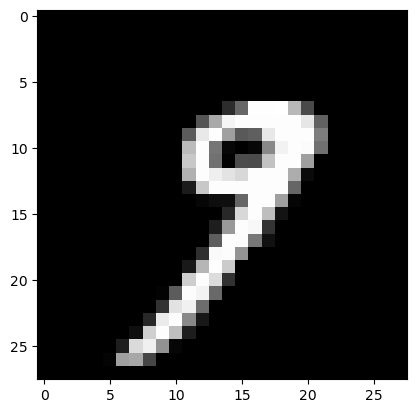

Prediction:  [7 2 1 ... 4 5 6]
Label:  7


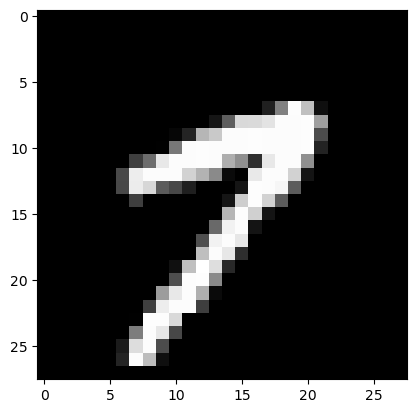

Prediction:  [7 2 1 ... 4 5 6]
Label:  6


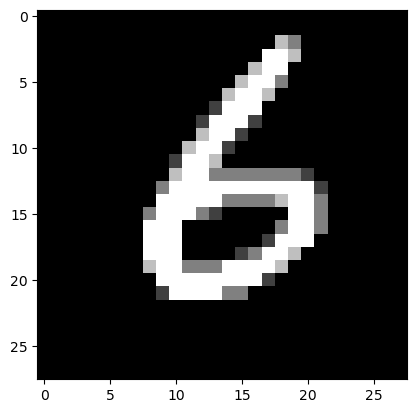

Prediction:  [7 2 1 ... 4 5 6]
Label:  5


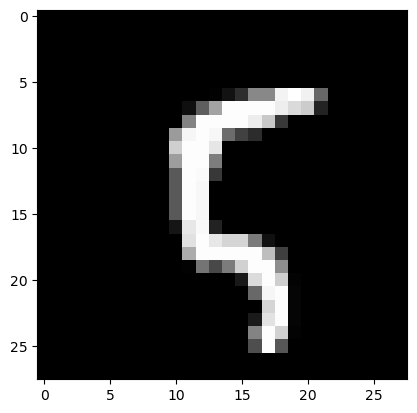

Prediction:  [7 2 1 ... 4 5 6]
Label:  0


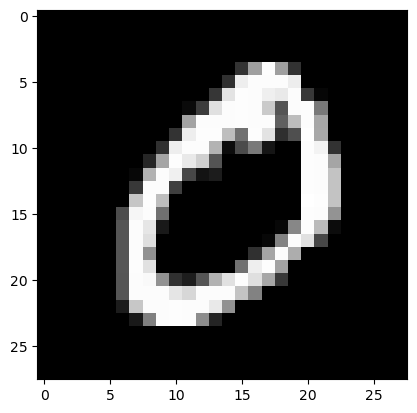

Prediction:  [7 2 1 ... 4 5 6]
Label:  7


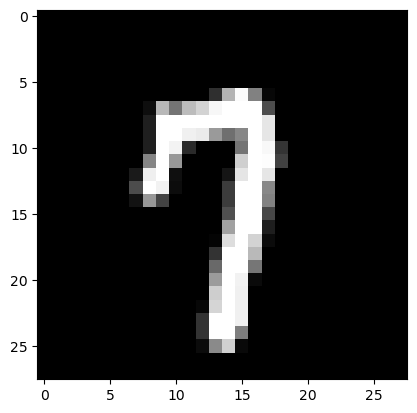

[7 3 8 ... 7 2 6] [7 3 8 ... 7 2 5]


In [33]:
def forward1(X_flattened, W1, b1, W2, b2, W3, b3):
    n = X_flattened.shape[0]  
    Z1 = np.dot(X_flattened, W1) + b1[:n, :]  # (nx hiddenunits1)
    A1 = relu(Z1)

    Z2 = np.dot(A1, W2) + b2[:n, :] 
    A2 = relu(Z2)

    Z3 = np.dot(A2, W3) + b3[:n, :]  
    A3 = softmax(Z3)

    return Z1, A1, Z2, A2, Z3, A3

#Z1_train, A1_train, Z2_train, A2_train, Z3_train, A3_train = forward(x_train_aug_flat, W11, b11, W21, b21, W31, b31)

#predictions_train = get_predictions(A3_train)  
#accuracy_train = get_accuracy(predictions_train, y_train1) 
#print("Training Accuracy:", accuracy_train)

Z1_test, A1_test, Z2_test, A2_test, Z3_test, A3_test = forward1(x_test_flat, W11, b11, W21, b21, W31, b31)

predictions_test = get_predictions(A3_test)  
accuracy_test = get_accuracy(predictions_test, y_test)  
print("Testing Accuracy:", accuracy_test)
def make_predictions(x_test_flat, W1, b1, W2, b2,W3,b3):
    _,_,_, _, _, A3_test = forward1(x_test_flat,W1, b1, W2, b2, W3,b3)
    predictions = get_predictions(A3_test)
    return predictions

def test_prediction(index,A3_test):
    current_image = x_train[ index,:, None]
   # prediction = get_predictions(x_train[:, index, None], W1, b1, W2, b2,W3,b3)
    predictions_test = get_predictions(A3_test)  

    label = y_train[index]
    print("Prediction: ", predictions_test)
    print("Label: ", label)
    
    current_image = current_image.reshape(( 28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

test_prediction(10,A3_test)
test_prediction(17, A3_test)
test_prediction(23,A3_test)
test_prediction(33,  A3_test)
test_prediction(79,  A3_test)
test_prediction(66,  A3_test)
test_prediction(100,  A3_test)
test_prediction(1,  A3_test)
test_prediction(21000,  A3_test)



Z1_val, A1_val, Z2_val, A2_val, Z3_val, A3_val = forward1(x_val_flat, W11, b11, W21, b21, W31, b31)

predictions_val = get_predictions(A3_val)  
accuracy_val = get_accuracy(predictions_val, y_val)  
#print("Val Accuracy:", accuracy_val)

#report1 = classification_report(y_train1, predictions_train)

#print(report1)

report2 = classification_report(y_test, predictions_test)

#print(report2)

report3 = classification_report(y_val, predictions_val)

#print(report3)